## Импорт либ

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve

from sklearn.inspection import permutation_importance

import joblib

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(23,8)}, style="whitegrid")

### Обработка датасета

In [2]:
#df = pd.read_csv('https://raw.githubusercontent.com/evgpat/edu_stepik_from_idea_to_mvp/main/datasets/clients.csv')
df = pd.read_csv('clients.csv')

In [3]:
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("-", "_")
df.columns = df.columns.str.replace("/", "_")
df.columns = df.columns.str.lower()

In [4]:
df_f = df.query('age < 87 and \
                flight_distance < 4000 and \
                arrival_delay_in_minutes < 300 and \
                departure_delay_in_minutes < 300 and \
                inflight_wifi_service <= 5 and \
                departure_arrival_time_convenient <= 5 and \
                ease_of_online_booking <= 5 and \
                gate_location <= 5 and \
                food_and_drink <= 5 and \
                online_boarding <= 5 and \
                seat_comfort <= 5 and \
                inflight_entertainment <= 5 and \
                on_board_service <= 5 and \
                leg_room_service <= 5 and \
                baggage_handling <= 5 and \
                checkin_service <= 5 and \
                inflight_service <= 5 and \
                cleanliness <= 5')

In [5]:
code_nums = {"gender": {"Male": 1, "Female": 0},
             "customer_type": {"Loyal Customer": 1, "disloyal Customer": 0},
             "type_of_travel": {"Personal Travel": 0, "Business travel": 1}, 
             "satisfaction": {"neutral or dissatisfied": 0, "satisfied": 1, "-": np.nan}}

In [6]:
df_f = df_f.replace(code_nums)

In [7]:
df_f = pd.get_dummies(df_f, prefix = ['c'],
                          columns = ['class'],
                          drop_first = False)

In [8]:
df_f = df_f.dropna()

### Подготовка выборок

In [9]:
X = df_f.drop(columns = ['satisfaction', 'id'])
y = df_f.satisfaction

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape

((70581, 24), (30250, 24))

### Обучем градиентный бустинг

In [11]:
model_3 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=600, subsample=1.0,
                                     criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0,
                                     init=None, random_state=42)
model_3.fit(X_train, y_train)
pred_3 = model_3.predict(X_test)

In [12]:
confusion_matrix(y_test, pred_3)

array([[16811,   372],
       [  689, 12378]], dtype=int64)

In [13]:
pred_proba_train_3 = model_3.predict_proba(X_train)
pred_proba_test_3 = model_3.predict_proba(X_test)
    
fpr_train_3, tpr_train_3, _ = roc_curve(y_train, pred_proba_train_3[:, 1])
fpr_test_3, tpr_test_3, _ = roc_curve(y_test, pred_proba_test_3[:, 1])

precision_test_3, recall_test_3, thresholds_test_3 = precision_recall_curve(y_test, pred_proba_test_3[:, 1])      
f1_3 = 2 * precision_test_3 * recall_test_3  / (precision_test_3 + recall_test_3)

beta = 0.5
f_beta_3 = (1 + beta**2) * precision_test_3 * recall_test_3  / (beta**2 * precision_test_3 + recall_test_3)

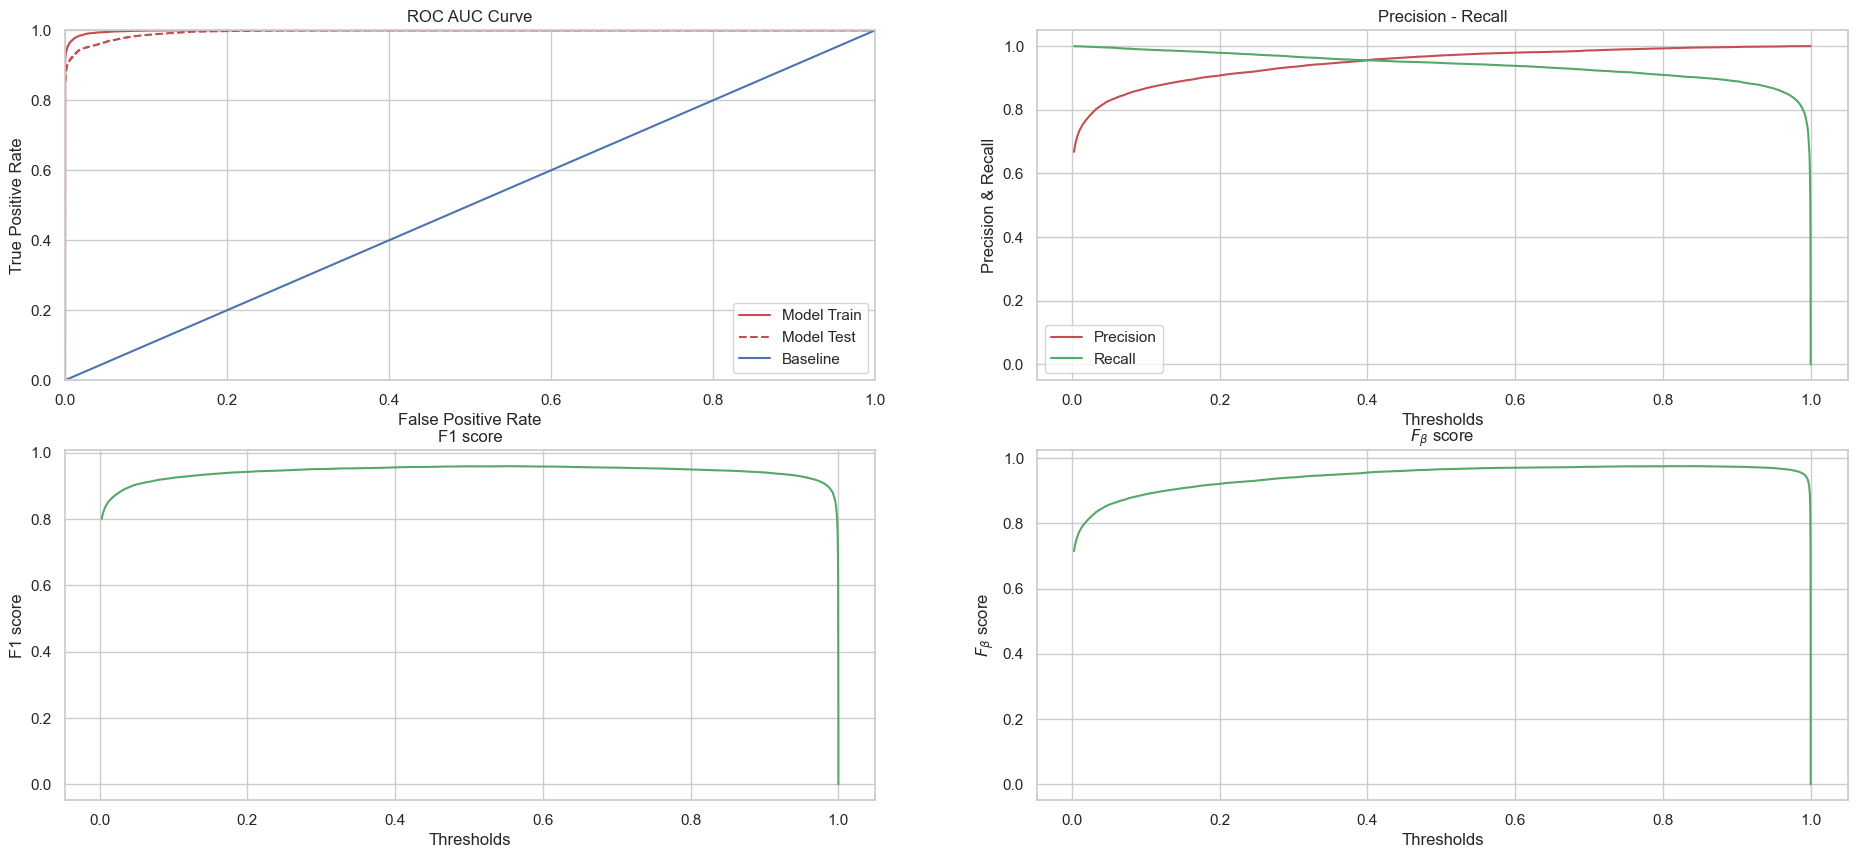

In [14]:
fig, axes = plt.subplots(2, 2, figsize = (23, 10))

axes[0][0].plot(fpr_train_3, tpr_train_3, 'r', label = 'Model Train')
axes[0][0].plot(fpr_test_3, tpr_test_3, 'r--', label = 'Model Test')
axes[0][0].plot([0, 1], [0, 1], 'b', label = 'Baseline')
axes[0][0].set_xlim([0.0, 1.0])
axes[0][0].set_ylim([0.0, 1.0])
axes[0][0].set_xlabel('False Positive Rate')
axes[0][0].set_ylabel('True Positive Rate')
axes[0][0].legend(loc = "lower right")
axes[0][0].set_title('ROC AUC Curve')


axes[0][1].plot(np.append(thresholds_test_3, 1.0), precision_test_3, 'r', label = 'Precision')
axes[0][1].plot(np.append(thresholds_test_3, 1.0), recall_test_3, 'g', label = 'Recall')
axes[0][1].set_xlabel('Thresholds')
axes[0][1].set_ylabel('Precision & Recall')
axes[0][1].legend(loc = "lower left")
axes[0][1].set_title('Precision - Recall')


axes[1][0].plot(np.append(thresholds_test_3, 1.0), f1_3, 'g')
axes[1][0].set_xlabel('Thresholds')
axes[1][0].set_ylabel('F1 score')
axes[1][0].set_title('F1 score')

axes[1][1].plot(np.append(thresholds_test_3, 1.0), f_beta_3, 'g')
axes[1][1].set_xlabel('Thresholds')
axes[1][1].set_ylabel(r'$F_{\beta}$' + ' score')
axes[1][1].set_title(r'$F_{\beta}$' + ' score')
       
plt.show()

In [15]:
ind_max_f1_3 = np.where(f1_3 == max(f1_3))[0][0]
ind_max_f_beta_3 = np.where(f_beta_3 == max(f_beta_3))[0][0]

print('F1 Score = {s[0]}:  F_beta Score = {s[1]}  Recall = {s[2]}  Precision = {s[3]}'.\
     format(s = [round(f1_3[ind_max_f1_3], 3),
                 round(f_beta_3[ind_max_f1_3], 3),
                 round(recall_test_3[ind_max_f1_3], 3),
                 round(precision_test_3[ind_max_f1_3], 3)]))

print('F1 Score = {s[0]}:  F_beta Score = {s[1]}  Recall = {s[2]}  Precision = {s[3]}'.\
     format(s = [round(f1_3[ind_max_f_beta_3], 3),
                 round(f_beta_3[ind_max_f_beta_3], 3),
                 round(recall_test_3[ind_max_f_beta_3], 3),
                 round(precision_test_3[ind_max_f_beta_3], 3)]))

F1 Score = 0.959:  F_beta Score = 0.97  Recall = 0.943  Precision = 0.977
F1 Score = 0.949:  F_beta Score = 0.976  Recall = 0.909  Precision = 0.994


In [16]:
r = permutation_importance(model_3, X_test, y_test, n_repeats=10, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{df_f.columns.values.tolist()[i]:<3}"
              f"    {r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

customer_type    0.157 +/- 0.002
arrival_delay_in_minutes    0.138 +/- 0.002
age    0.078 +/- 0.001
food_and_drink    0.027 +/- 0.001
leg_room_service    0.024 +/- 0.001
checkin_service    0.022 +/- 0.001
baggage_handling    0.021 +/- 0.001
online_boarding    0.017 +/- 0.001
inflight_service    0.010 +/- 0.000
departure_arrival_time_convenient    0.007 +/- 0.000
gender    0.006 +/- 0.000
cleanliness    0.006 +/- 0.000
inflight_entertainment    0.005 +/- 0.001
seat_comfort    0.004 +/- 0.000
ease_of_online_booking    0.003 +/- 0.000
type_of_travel    0.003 +/- 0.000
departure_delay_in_minutes    0.003 +/- 0.000
inflight_wifi_service    0.002 +/- 0.000
on_board_service    0.002 +/- 0.000
flight_distance    0.001 +/- 0.000
gate_location    0.001 +/- 0.000
satisfaction    0.000 +/- 0.000


Существенными факторами, влияющими на классификацию являются: 
1. Тип клиента, лояльный или нет
2. Задержка прибытия
3. Возраст

Интересен момент, что задержка прибытия очень важна, мне казалось, что больше раздражает задержка подачи самолета

Скор еще лучше, пока будем использовать эту модель

### Сохраняем model_3

In [17]:
filename = 'gradient_best.sav'
joblib.dump(model_3, filename)

['gradient_best.sav']

In [18]:
loaded_model = joblib.load('gradient_best.sav')
result = loaded_model.score(X_test, y_test)
print(result)

0.9649256198347107


## Создаем новый датасет для замены "-" в таргете на предсказанные значения

In [19]:
df_new = df.query('satisfaction == "-"')

In [20]:
df_new = df_new.replace(code_nums)

In [21]:
df_new = pd.get_dummies(df_new, prefix = ['c'],
                          columns = ['class'],
                          drop_first = False)

In [22]:
df_new = df_new.drop(columns=['id', 'satisfaction'])

In [23]:
df_new.isna().sum()

gender                                71
age                                   55
customer_type                         11
type_of_travel                        13
flight_distance                       22
departure_delay_in_minutes            23
arrival_delay_in_minutes             102
inflight_wifi_service                 12
departure_arrival_time_convenient      8
ease_of_online_booking                10
gate_location                          7
food_and_drink                        15
online_boarding                        9
seat_comfort                           7
inflight_entertainment                 3
on_board_service                      12
leg_room_service                      10
baggage_handling                      16
checkin_service                        8
inflight_service                      14
cleanliness                            6
c_Business                             0
c_Eco                                  0
c_Eco Plus                             0
dtype: int64

In [24]:
df_new = df_new.dropna()

### Получаем предсказания для "-" и добавляем их вместо "-"

In [25]:
pred_new = loaded_model.predict(df_new)

In [26]:
df_new['satisfaction'] = pred_new

### Создаем новый датафрейм для обучения где "-" уже заменены на предсказания

In [27]:
df_new['id'] = df.id

In [28]:
new = df.dropna()

In [29]:
new = new.replace(code_nums)

In [30]:
new = new.merge(df_new[['satisfaction','id']], on='id', how='left')

In [31]:
new['satisfaction'] = new['satisfaction_x'].fillna(0) + new['satisfaction_y'].fillna(0)

In [32]:
new = new.drop(columns=['satisfaction_x', 'satisfaction_y'])

In [33]:
new = pd.get_dummies(new, prefix = ['c'],
                          columns = ['class'],
                          drop_first = False)

In [34]:
new

,id,gender,age,customer_type,type_of_travel,flight_distance,departure_delay_in_minutes,arrival_delay_in_minutes,inflight_wifi_service,departure_arrival_time_convenient,...,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,satisfaction,c_Business,c_Eco,c_Eco Plus
0,1,1,48.0,0,1,821.0,2.0,5.0,3.0,3.0,...,3.0,2.0,5.0,4.0,5.0,5.0,0.0,1,0,0
1,2,0,35.0,1,1,821.0,26.0,39.0,2.0,2.0,...,5.0,5.0,5.0,3.0,5.0,5.0,1.0,1,0,0
2,3,1,41.0,1,1,853.0,0.0,0.0,4.0,4.0,...,3.0,3.0,3.0,4.0,3.0,5.0,1.0,1,0,0
3,4,1,50.0,1,1,1905.0,0.0,0.0,2.0,2.0,...,5.0,5.0,5.0,3.0,5.0,4.0,1.0,1,0,0
4,5,0,49.0,1,1,3470.0,0.0,1.0,3.0,3.0,...,3.0,4.0,3.0,3.0,3.0,5.0,1.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127599,129875,0,55.0,1,0,308.0,0.0,0.0,3.0,4.0,...,4.0,3.0,4.0,4.0,4.0,4.0,0.0,0,0,1
127600,129876,1,28.0,1,0,447.0,2.0,3.0,4.0,4.0,...,5.0,4.0,4.0,4.0,5.0,4.0,0.0,0,0,1
127601,129878,1,42.0,1,0,337.0,6.0,14.0,2.0,5.0,...,3.0,4.0,5.0,4.0,4.0,3.0,0.0,0,0,1
127602,129879,1,50.0,1,0,337.0,31.0,22.0,5.0,4.0,...,4.0,5.0,5.0,3.0,4.0,3.0,1.0,0,0,1


In [35]:
new_test = new

In [48]:
new_test = new_test.drop(columns=['id', 'flight_distance'])

In [49]:
new_test

,gender,age,customer_type,type_of_travel,departure_delay_in_minutes,arrival_delay_in_minutes,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,...,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,satisfaction,c_Business,c_Eco,c_Eco Plus
0,1,48.0,0,1,2.0,5.0,3.0,3.0,3.0,3.0,...,3.0,2.0,5.0,4.0,5.0,5.0,0.0,1,0,0
1,0,35.0,1,1,26.0,39.0,2.0,2.0,2.0,2.0,...,5.0,5.0,5.0,3.0,5.0,5.0,1.0,1,0,0
2,1,41.0,1,1,0.0,0.0,4.0,4.0,4.0,4.0,...,3.0,3.0,3.0,4.0,3.0,5.0,1.0,1,0,0
3,1,50.0,1,1,0.0,0.0,2.0,2.0,2.0,2.0,...,5.0,5.0,5.0,3.0,5.0,4.0,1.0,1,0,0
4,0,49.0,1,1,0.0,1.0,3.0,3.0,3.0,3.0,...,3.0,4.0,3.0,3.0,3.0,5.0,1.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127599,0,55.0,1,0,0.0,0.0,3.0,4.0,3.0,4.0,...,4.0,3.0,4.0,4.0,4.0,4.0,0.0,0,0,1
127600,1,28.0,1,0,2.0,3.0,4.0,4.0,4.0,2.0,...,5.0,4.0,4.0,4.0,5.0,4.0,0.0,0,0,1
127601,1,42.0,1,0,6.0,14.0,2.0,5.0,2.0,1.0,...,3.0,4.0,5.0,4.0,4.0,3.0,0.0,0,0,1
127602,1,50.0,1,0,31.0,22.0,5.0,4.0,4.0,1.0,...,4.0,5.0,5.0,3.0,4.0,3.0,1.0,0,0,1


In [50]:
new_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127604 entries, 0 to 127603
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             127604 non-null  int64  
 1   age                                127604 non-null  float64
 2   customer_type                      127604 non-null  int64  
 3   type_of_travel                     127604 non-null  int64  
 4   departure_delay_in_minutes         127604 non-null  float64
 5   arrival_delay_in_minutes           127604 non-null  float64
 6   inflight_wifi_service              127604 non-null  float64
 7   departure_arrival_time_convenient  127604 non-null  float64
 8   ease_of_online_booking             127604 non-null  float64
 9   gate_location                      127604 non-null  float64
 10  food_and_drink                     127604 non-null  float64
 11  online_boarding                    1276

In [51]:
new_test.to_csv('clients_mod.csv',index=False)

### Создаем обучающую выборку

In [73]:
new_test = pd.read_csv('clients_mod.csv')

In [74]:
X1 = new_test.drop(columns=['satisfaction'])
y1 = new_test.satisfaction

In [75]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

X1_train.shape, X1_test.shape

((89322, 23), (38282, 23))

### Обучаем модель

In [76]:
model_30 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, subsample=1.0,
                                     criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0, max_depth=5, min_impurity_decrease=0.0,
                                     init=None, random_state=42)
model_30.fit(X1_train, y1_train)
pred_30 = model_30.predict(X1_test)

In [77]:
confusion_matrix(y1_test, pred_30)

array([[21193,   382],
       [  822, 15885]], dtype=int64)

In [89]:
r = permutation_importance(model_30, X1_test, y1_test, n_repeats=10, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X1.columns.values.tolist()[i]:<3}"
              f"    {r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

type_of_travel    0.156 +/- 0.001
inflight_wifi_service    0.145 +/- 0.001
customer_type    0.076 +/- 0.001
online_boarding    0.027 +/- 0.001
inflight_service    0.024 +/- 0.001
baggage_handling    0.024 +/- 0.001
checkin_service    0.020 +/- 0.000
seat_comfort    0.016 +/- 0.001
cleanliness    0.012 +/- 0.000
c_Business    0.011 +/- 0.000
ease_of_online_booking    0.009 +/- 0.000
age    0.007 +/- 0.000
on_board_service    0.005 +/- 0.001
gate_location    0.003 +/- 0.000
inflight_entertainment    0.003 +/- 0.000
arrival_delay_in_minutes    0.003 +/- 0.000
departure_arrival_time_convenient    0.001 +/- 0.000
leg_room_service    0.001 +/- 0.000
food_and_drink    0.000 +/- 0.000


В данном случае вес имеют параметры типа полета, вайфая в самолете и лояльности клиента

In [83]:
pred_proba_train_30 = model_30.predict_proba(X1_train)
pred_proba_test_30 = model_30.predict_proba(X1_test)
    
fpr_train_30, tpr_train_30, _ = roc_curve(y1_train, pred_proba_train_30[:, 1])
fpr_test_30, tpr_test_30, _ = roc_curve(y1_test, pred_proba_test_30[:, 1])

precision_test_30, recall_test_30, thresholds_test_30 = precision_recall_curve(y1_test, pred_proba_test_30[:, 1])      
f1_30 = 2 * precision_test_30 * recall_test_30  / (precision_test_30 + recall_test_30)

beta = 0.5
f_beta_30 = (1 + beta**2) * precision_test_30 * recall_test_30  / (beta**2 * precision_test_30 + recall_test_30)

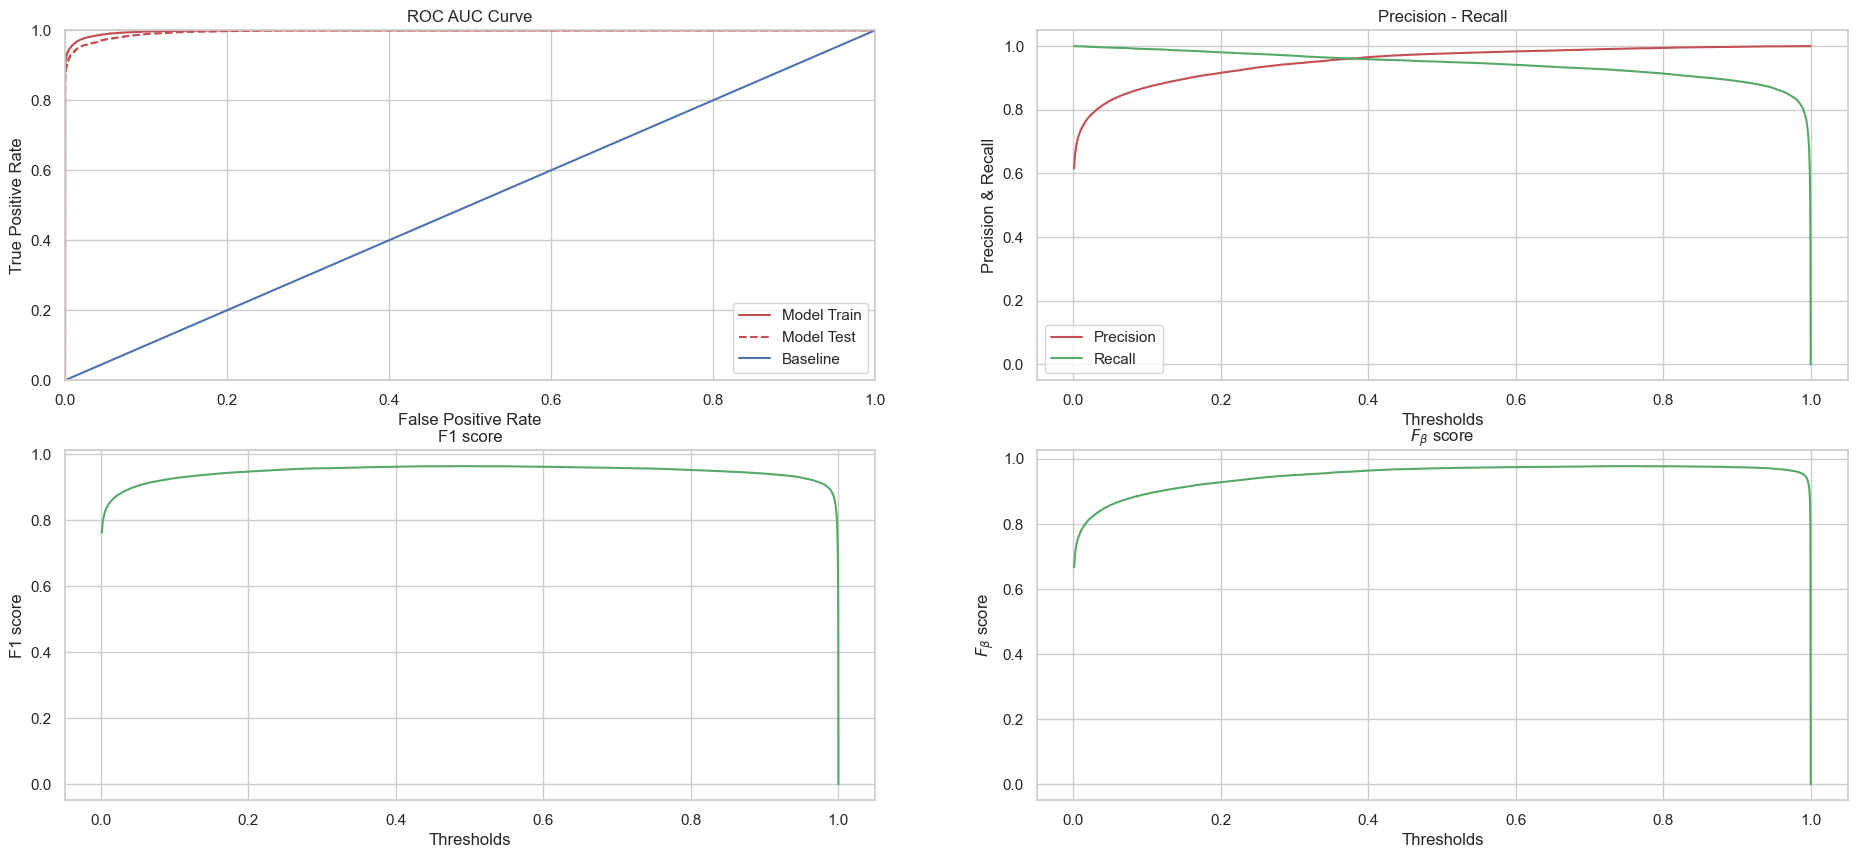

In [84]:
fig, axes = plt.subplots(2, 2, figsize = (23, 10))

axes[0][0].plot(fpr_train_30, tpr_train_30, 'r', label = 'Model Train')
axes[0][0].plot(fpr_test_30, tpr_test_30, 'r--', label = 'Model Test')
axes[0][0].plot([0, 1], [0, 1], 'b', label = 'Baseline')
axes[0][0].set_xlim([0.0, 1.0])
axes[0][0].set_ylim([0.0, 1.0])
axes[0][0].set_xlabel('False Positive Rate')
axes[0][0].set_ylabel('True Positive Rate')
axes[0][0].legend(loc = "lower right")
axes[0][0].set_title('ROC AUC Curve')


axes[0][1].plot(np.append(thresholds_test_30, 1.0), precision_test_30, 'r', label = 'Precision')
axes[0][1].plot(np.append(thresholds_test_30, 1.0), recall_test_30, 'g', label = 'Recall')
axes[0][1].set_xlabel('Thresholds')
axes[0][1].set_ylabel('Precision & Recall')
axes[0][1].legend(loc = "lower left")
axes[0][1].set_title('Precision - Recall')


axes[1][0].plot(np.append(thresholds_test_30, 1.0), f1_30, 'g')
axes[1][0].set_xlabel('Thresholds')
axes[1][0].set_ylabel('F1 score')
axes[1][0].set_title('F1 score')

axes[1][1].plot(np.append(thresholds_test_30, 1.0), f_beta_30, 'g')
axes[1][1].set_xlabel('Thresholds')
axes[1][1].set_ylabel(r'$F_{\beta}$' + ' score')
axes[1][1].set_title(r'$F_{\beta}$' + ' score')
       
plt.show()

In [85]:
ind_max_f1_30 = np.where(f1_30 == max(f1_30))[0][0]
ind_max_f_beta_30 = np.where(f_beta_30 == max(f_beta_30))[0][0]

print('F1 Score = {s[0]}:  F_beta Score = {s[1]}  Recall = {s[2]}  Precision = {s[3]}'.\
     format(s = [round(f1_30[ind_max_f1_30], 3),
                 round(f_beta_30[ind_max_f1_30], 3),
                 round(recall_test_30[ind_max_f1_30], 3),
                 round(precision_test_30[ind_max_f1_30], 3)]))

print('F1 Score = {s[0]}:  F_beta Score = {s[1]}  Recall = {s[2]}  Precision = {s[3]}'.\
     format(s = [round(f1_30[ind_max_f_beta_30], 3),
                 round(f_beta_30[ind_max_f_beta_30], 3),
                 round(recall_test_30[ind_max_f_beta_30], 3),
                 round(precision_test_30[ind_max_f_beta_30], 3)]))

F1 Score = 0.964:  F_beta Score = 0.969  Recall = 0.955  Precision = 0.973
F1 Score = 0.956:  F_beta Score = 0.978  Recall = 0.921  Precision = 0.993


In [86]:
model_30.score(X1_test, y1_test)

0.968549187607753

In [87]:
joblib.dump(model_30, 'best_model.sav')

['best_model.sav']

### Минимизируем число признаков

In [3]:
new_test = pd.read_csv('clients_mod.csv')

In [4]:
new_test = new_test.drop(columns=['c_Business', 'c_Eco', 'c_Eco Plus',
                            'departure_delay_in_minutes', 'arrival_delay_in_minutes',
                            'leg_room_service', 'gate_location'])

In [5]:
new_test.to_csv('clients_fin.csv',index=False)

In [6]:
X1 = new_test.drop(columns=['satisfaction'])
y1 = new_test.satisfaction

In [7]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

X1_train.shape, X1_test.shape

((89322, 16), (38282, 16))

In [8]:
model_30 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, subsample=1.0,
                                     criterion='friedman_mse', min_samples_split=6, min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0, max_depth=6, min_impurity_decrease=0.0,
                                     init=None, random_state=42)
model_30.fit(X1_train, y1_train)
pred_30 = model_30.predict(X1_test)

In [9]:
confusion_matrix(y1_test, pred_30)

array([[21090,   485],
       [  857, 15850]], dtype=int64)

In [10]:
r = permutation_importance(model_30, X1_test, y1_test, n_repeats=10, random_state=42)
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X1.columns.values.tolist()[i]:<3}"
              f"    {r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

type_of_travel    0.197 +/- 0.002
inflight_wifi_service    0.146 +/- 0.001
customer_type    0.095 +/- 0.001
inflight_service    0.042 +/- 0.001
baggage_handling    0.038 +/- 0.001
online_boarding    0.035 +/- 0.001
checkin_service    0.029 +/- 0.000
seat_comfort    0.028 +/- 0.001
cleanliness    0.023 +/- 0.001
ease_of_online_booking    0.011 +/- 0.000
inflight_entertainment    0.010 +/- 0.000
on_board_service    0.009 +/- 0.001
age    0.008 +/- 0.001
departure_arrival_time_convenient    0.005 +/- 0.000
food_and_drink    0.002 +/- 0.001
gender    0.001 +/- 0.000


In [11]:
joblib.dump(model_30, 'model_fin.sav')

['model_fin.sav']

### Для readme

В данном ноутбуке уже вся выжимка, был еще ноут где я исследовал выборку, решал как резать фрейм, что удалять и по какому принципу.
Тут мною решалась главная занвоздка - "-" в таргетном столбце, короче! Как мне кажется - решение гениальное! Итак я лучшая модель - градиентный бустинг, она скорее всего немного переобучилась и выдала средний скор в 96,5%, дальше я натравил ее на признаки для таргета "-" и получил какое-то предсказание, априори считаю что с в 96,5% случаях я попал. Дальше матчу эти предсказания в основной набор данных и сосдаю новую выборку, где "-" уже заменены на релевантные 0 и 1, дальше сновна натравливаю модель на поплненную выборку и обучаюсь.

В ТЕОРИИ эти нехитрым мувом я:
1. Избавился от преславутого "-"
2. Увеличил объем выборки
3. Внес в данные некоторый шум, ибо модель не точна, данные не точны, это должно мешать переобучению

Итак, моя модель лучше отличает негативных/ нейтральных чем позитивных, и это даже хорошо, лучше выявлять неудовлетворенных и работать с ними, ориентироваться будем больше на метрику precision